In [169]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.table import Table
from astropy.io import fits

from scipy.stats import truncnorm
from skimage.util import view_as_windows

In [41]:
PATH_DATA = '/Volumes/ES-LaCie/Documents/MATLAS'
PATH_SAVE = '/Volumes/ES-LaCie/Documents/MATLAS/Data/r_band'

In [42]:
# Load the Galaxies in MATLAS
galaxies = np.loadtxt(f'{PATH_DATA}/galaxies.txt', dtype=str)

# Correct between the names in the catalog and the names in the images
real_galaxies_missing = np.array(['IC0719', 'NGC3400', 'NGC3499', 'NGC3613', 'NGC3630', 'NGC4249', 'NGC4255', 'NGC5173', 'NGC5353', 'NGC5473', 'NGC5839'])
real_corresponding_tiles = np.array(['IC0719', 'NGC3414', 'NGC3499', 'NGC3619', 'NGC3640', 'NGC4259', 'NGC4255', 'NGC5198', 'NGC5355', 'NGC5485', 'NGC5845'])
real_galaxies_to_tile = dict(zip(real_galaxies_missing, real_corresponding_tiles))

for i in range(len(galaxies)):
    if galaxies[i] in real_galaxies_missing:
        galaxies[i] = real_galaxies_to_tile[galaxies[i]]

In [252]:
index = 7

# Load r-band image
with fits.open(f'{PATH_DATA}/{galaxies[index]}.l.r.Mg004.fits') as hdul:
    primary_hdu = hdul[0]
    data_r = primary_hdu.data.T  # This is a NumPy array
    header_r = primary_hdu.header  # This is a FITS header object

In [441]:
# Load center position of Dwarfs in RA and DEC in the Catalogue
df = Table.read(f'{PATH_DATA}/MATLAS_dwarfs_Poulain2021.tsv', format='ascii.csv', delimiter=';')
ra_dwarf, dec_dwarf, id_dwarfs, host = np.array(df['RAJ2000']), np.array( df['DEJ2000']), np.array( df['ID']), np.array( df['HostETG'])

catalogue_wrong = np.array(['NGC0525', 'NGC2594', 'NGC2699', 'NGC3665', 'NGC4251', 'NGC7465'])
catalogue_right = np.array(['NGC0524', 'NGC2592', 'NGC2695', 'NGC3658', 'NGC4251', 'NGC7457'])
wrong_to_right = dict(zip(catalogue_wrong, catalogue_right))

for i in range(len(host)):
    if host[i] in catalogue_wrong:
        host[i] = wrong_to_right[host[i]]

host_filter = host == galaxies[index]

# Get the pixel corners of the image
x_pixels, y_pixels = data_r.shape

# Get dwarfs coordinates in pixels
w = wcs.WCS(header_r)
dwarf_x_pixel, dwarf_y_pixel = np.round( w.wcs_world2pix(ra_dwarf, dec_dwarf, 0) ).astype(int)
dwarf_x_pixel, dwarf_y_pixel, id_dwarfs = dwarf_x_pixel[host_filter], dwarf_y_pixel[host_filter], id_dwarfs[host_filter]

dwarf_segmentation = np.zeros_like(data_r, dtype=int)
for i in range(len(dwarf_x_pixel)):
    dwarf_segmentation[dwarf_x_pixel[i], dwarf_y_pixel[i]] += 1

/var/folders/bz/ftchh2fx1mzg7zrsqk32mjp40000gn/T/ipykernel_75261/2353367623.py:20: RuntimeWarning: invalid value encountered in cast
  dwarf_x_pixel, dwarf_y_pixel = np.round( w.wcs_world2pix(ra_dwarf, dec_dwarf, 0) ).astype(int)


In [442]:
np.unique(host)[ np.isin(np.unique(host), galaxies) == 0 ]

array(['NGC4251'], dtype='<U9')

In [257]:
def slidding_window(arr, window_shape=(2, 224, 224)):
    # # Ensure the dimensions are divisible by the window shape
    # x_shape, y_shape = arr.shape
    # x_size = window_shape[0] * ( x_shape // window_shape[0] )
    # y_size = window_shape[1] * ( y_shape // window_shape[1] )

    # corrected_arr = arr[:x_size, :y_size]

    # Use view_as_windows to slice the array into windows
    windows = view_as_windows(arr, window_shape, window_shape)

    # Since windows is a 4D array, you need to reshape it to a 3D array where
    # each window is a separate element in the array.
    # First, get the number of windows in each dimension
    num_windows_y, num_windows_x = windows.shape[1:3]

    # Reshape while keeping each window intact
    windows = windows.reshape(num_windows_y * num_windows_x, *window_shape)
    return windows

# Get the blocks
array = np.concatenate([data_r[None], dwarf_segmentation[None]], axis=0)
blocks = slidding_window(array)
print(f"Total blocks extracted: {len(blocks)}")


Total blocks extracted: 15720


In [278]:
os.makedirs(f'{PATH_SAVE}/{galaxies[index]}', exist_ok=True)

arg_TP = np.where(blocks[:, 1].sum(axis=(1,2)) > 0)[0]
i_coord, x_coord, y_coord = np.where( blocks[arg_TP, 1] > 0 )
xy_label = np.zeros((len(x_coord), 3))
xy_label[:, 0] = i_coord
xy_label[:, 1] = x_coord
xy_label[:, 2] = y_coord
with h5py.File(f'{PATH_SAVE}/{galaxies[index]}/TP.h5', 'w') as f:
    f.create_dataset("data",  data=blocks[arg_TP, 0])
    f.create_dataset("label", data=xy_label)

NN = 1000
lower_bound, upper_bound = 0, len(blocks)
mean, std_dev = len(blocks)/2, len(blocks)/5
a, b = (lower_bound - mean) / std_dev, (upper_bound - mean) / std_dev
int_samples = truncnorm.rvs(a, b, loc=mean, scale=std_dev, size=NN).astype(int)

def adjust_duplicates(array, arg_TP):
    seen = set(arg_TP)
    for index, value in enumerate(array):
        while value in seen:
            value += 1  # Adjust incrementally
        seen.add(value)
        array[index] = value
    return array

arg_TN = adjust_duplicates(int_samples, arg_TP)
with h5py.File(f'{PATH_SAVE}/{galaxies[index]}/TN.h5', 'w') as f:
    f.create_dataset("data",  data=blocks[arg_TN, 0])

In [413]:
with h5py.File(f'{PATH_SAVE}/{galaxies[index]}/TN.h5', 'r') as f:
    TN_data = f['data'][:]

with h5py.File(f'{PATH_SAVE}/{galaxies[index]}/TP.h5', 'r') as f:
    TP_data = f['data'][:]
    TP_label = f['label'][:]

In [418]:
np.where( TN_data.sum(axis=(1,2)) == 0)[0].shape

(76,)

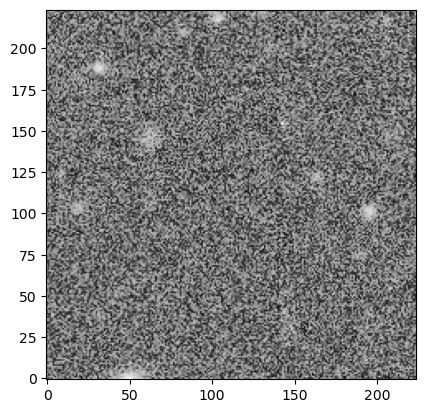

In [440]:
plt.imshow(np.arcsinh(TN_data[np.random.randint(NN)]).T, cmap='gray', origin='lower')

Text(0.5, 1.0, 'TP Seed: 19')

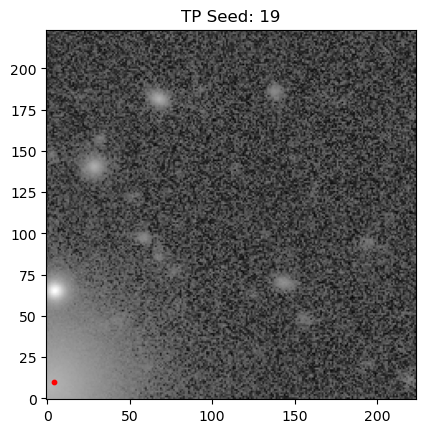

In [412]:
TP_seed = np.random.randint(len(TP_data))
plt.imshow(np.arcsinh(TP_data[TP_seed]).T, cmap='gray', origin='lower')

arg_dwarf = np.where(TP_label[:,0]==TP_seed)[0]
plt.scatter(TP_label[arg_dwarf,1], TP_label[arg_dwarf,2], c='r', s=10)
plt.title(f"TP Seed: {TP_seed}")